<a href="https://colab.research.google.com/github/PWhiddy/jax-experiments/blob/main/MegaParticles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap
import jax
from jax.experimental import sparse
import matplotlib.pyplot as plt
from tqdm import tqdm

In [75]:
!pip install --quiet mediapy einops

In [76]:
import mediapy as media
from einops import rearrange

In [111]:
key = jax.random.PRNGKey(110)
p_count = 1024*1024 #64*1024 # 2048 # 1024*1024 # 1024*1024*40
positions = jax.random.normal(key, (p_count, 2))
bright_scale = (100 / jnp.sqrt(p_count))
key, old = jax.random.split(key)
velocities = jnp.zeros((p_count, 2)) # jax.random.normal(key, (p_count, 2)) * 0.1 #
#positions = positions

In [78]:
def gaussian_kern(kernlen, nsig):
    """Returns a 2D Gaussian kernel."""

    x = jnp.linspace(-nsig, nsig, kernlen+1)
    kern1d = jnp.diff(jax.scipy.stats.norm.cdf(x))
    kern2d = jnp.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

In [79]:
def draw_single_sprite(pos, sprite, sp_width, sp_height, out_dims):
  channels = out_dims[2]
  numel = sp_width * sp_height * channels
  data = sprite.reshape(numel)
  raw_indices = jnp.indices((channels, sp_height, sp_width))
  indices = jnp.flip( raw_indices.T.reshape(-1, channels), 1).astype(jnp.int16)
  indices = indices.at[:, 0].set( indices[:, 0] + pos[0] )
  indices = indices.at[:, 1].set( indices[:, 1] + pos[1] )
  return sparse.BCOO((data, indices), shape=out_dims)

In [80]:
def draw_all_sprites(all_pos, all_indices, sprite_sheet, canv_dims):
  draw_bound = lambda p, sprite: draw_single_sprite(p, sprite, sprite_sheet.shape[1], sprite_sheet.shape[2], canv_dims)
  draw_all = vmap(draw_bound, in_axes=(0))
  render = draw_all(all_pos, sprite_sheet[all_indices]).sum(0)
  return jnp.clip(sparse.todense(render), 0, 255)# .astype(jnp.uint8) # render

In [81]:
draw_sprites_jit = jit(draw_all_sprites, static_argnums=(3,))

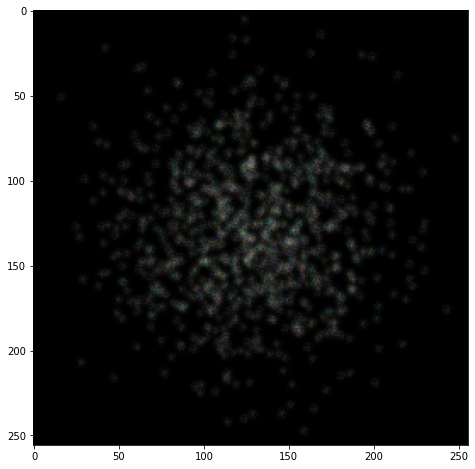

In [107]:
test_sprite_count = 8
test_sprite_dim = 13
test_random_sprites = jax.random.uniform(
    key, 
    (test_sprite_count, test_sprite_dim, test_sprite_dim, 3), 
    minval=0, 
    maxval=1
) * gaussian_kern(test_sprite_dim, 4.0).reshape(1, test_sprite_dim, test_sprite_dim, 1) * bright_scale 
test_sprite_indices = jax.random.randint(key, (p_count,), minval=0, maxval=test_sprite_count)
test_img_dim = 256#768
test_r = draw_sprites_jit(positions * 40 + test_img_dim//2 - test_sprite_dim//2, test_sprite_indices, test_random_sprites, (test_img_dim, test_img_dim, 3) )
plt.figure(figsize = (8,8))
plt.imshow(test_r)

In [26]:
vid_dim = 256
test_sprite_count = 1
test_sprite_dim = 13
test_random_sprites = jnp.tile(gaussian_kern(test_sprite_dim, 3.0).reshape(1, test_sprite_dim, test_sprite_dim, 1), 3) * bright_scale
test_sprite_indices = jnp.ones((p_count,), dtype=int)
temp_vel = jax.random.normal(key, (p_count, 2)) * 0.5 

with media.VideoWriter("test_simple_move.mp4", (vid_dim, vid_dim), crf=25) as wr:
  for i in tqdm(range(100)):
    test_r = draw_sprites_jit(
        positions * 40 + vid_dim//2 - test_sprite_dim//2 + temp_vel * i, 
        test_sprite_indices, 
        test_random_sprites, 
        (vid_dim, vid_dim, 3)
    )
    #test_r = jnp.minimum(test_r, 255).astype(jnp.uint8)
    wr.add_image(test_r)

100%|██████████| 200/200 [00:30<00:00,  6.47it/s]


In [83]:
sobel_x = jnp.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]       
])

sobel_y = jnp.array([
        [-1, -2, -1],
        [ 0,  0,  0], 
        [ 1,  2,  1]           
])

sobels = jnp.stack((sobel_x, sobel_y)).reshape(2, 1, 3, 3).astype(jnp.float32)
sobels.shape

(2, 1, 3, 3)

(1, 1, 1024, 1024)
(2, 1, 3, 3)
(1, 2, 1024, 1024)


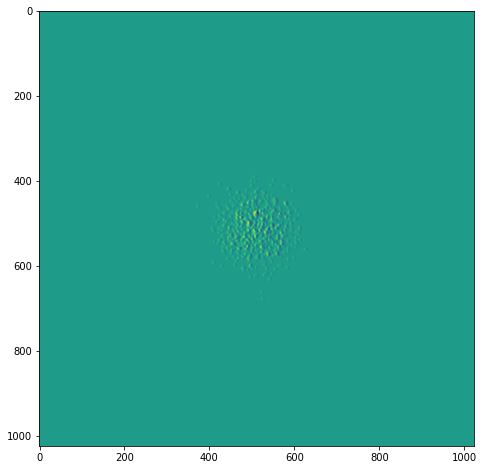

In [105]:
test_img = draw_sprites_jit(
        positions * 40 + vid_dim//2 - test_sprite_dim//2 + velocities * i, 
        test_sprite_indices, 
        test_random_sprites, 
        (vid_dim, vid_dim, 3)
    ).reshape(1, vid_dim, vid_dim, 3)
test_img_nchw = jnp.transpose(test_img[..., 0:1], [0,3,1,2])
print(test_img_nchw.shape)
print(sobels.shape)
dxdy = jax.lax.conv(test_img_nchw,    # lhs = NCHW image tensor
               sobels, # rhs = OIHW conv kernel tensor
               (1, 1),  # window strides
               'SAME', # padding mode
             )
print(dxdy.shape)
plt.figure(figsize = (8,8))
plt.imshow(dxdy[0, 0])

In [113]:
vid_dim = 1024
cur_pos = positions * 128 + vid_dim//2 - test_sprite_dim//2 # jnp.array([[20, 20], [23, 23], [50, 50], [53, 50], [80, 80], [80, 83], [100, 100]]) #
cur_vel = velocities * 1
test_random_sprites = jnp.tile(gaussian_kern(test_sprite_dim, 3.0).reshape(1, test_sprite_dim, test_sprite_dim, 1), 3) * bright_scale * 100
test_sprite_indices = jnp.ones((p_count,), dtype=int)

def new_state(pos, vel):
    test_r = draw_sprites_jit(
        pos - (test_sprite_dim // 2), 
        test_sprite_indices, 
        test_random_sprites, 
        (vid_dim, vid_dim, 3)
    )
    test_img_nchw = jnp.transpose(test_r.mean(-1).reshape(1, vid_dim, vid_dim, 1), [0,3,1,2])
    #print(test_img_nchw.shape)
    #print(sobels.shape)
    dxdy = jax.lax.conv(
      test_img_nchw, # lhs = NCHW image tensor
      sobels, # rhs = OIHW conv kernel tensor
      (1, 1),  # window strides
      'SAME', # padding mode
    )
    dxdy = jnp.transpose(dxdy, (0, 2, 3, 1))[0]
    coords_int = jnp.clip(pos, 0, vid_dim).astype(jnp.int16)
    #print(dxdy[coords_int[:, 0], coords_int[:, 1]].shape)
    #print(f"total vel change = {dxdy.sum()}")
    charge_grads = 0.001 * dxdy[coords_int[:, 0], coords_int[:, 1]]
    #print(charge_grads)
    cur_vel = (vel - charge_grads) * 0.99 # damping
    cur_pos = pos + cur_vel * 0.2
    return cur_pos, cur_vel, test_r

new_state_jit = jit(new_state)

#print(cur_pos)
with media.VideoWriter("test_sim.mp4", (vid_dim, vid_dim), crf=25) as wr:
  for i in tqdm(range(100)):
    cur_pos, cur_vel, test_r = new_state_jit(cur_pos, cur_vel)
    wr.add_image(test_r.astype(jnp.uint8))

100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


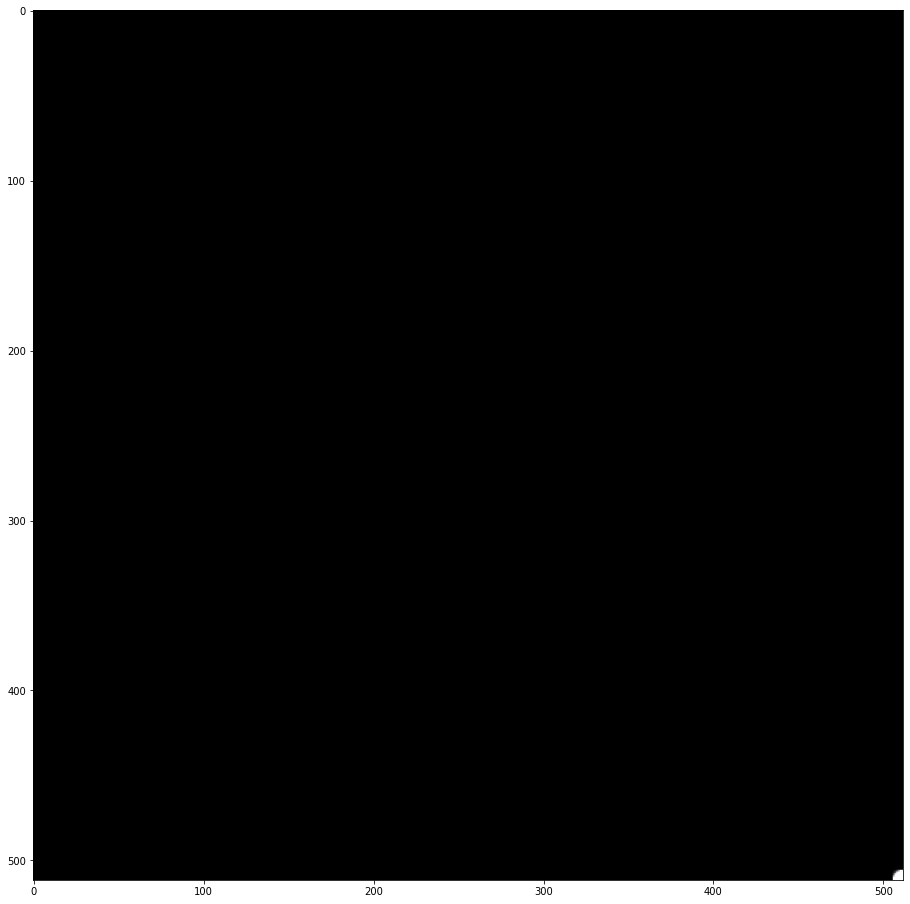

In [179]:
plt.figure(figsize = (16,16))
plt.imshow(
    draw_sprites_jit(
        jnp.array([[512 - test_sprite_dim // 2, 512 - test_sprite_dim // 2]]), #positions * 128 + vid_dim//2 - test_sprite_dim//2 + velocities * i, 
        jnp.array([0]), #test_sprite_indices, 
        test_random_sprites, 
        (vid_dim, vid_dim, 3)
    )
);

In [ ]:
""